<a href="https://colab.research.google.com/github/akanksha-th/brain_tumor_mri_classification/blob/master/notebooks/finetuned_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/akanksha-th/brain_tumor_mri_classification/blob/master/finetuned_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os, math, numpy as np, random, time
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [14]:
print(f'Torch version: {torch.__version__}')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Torch version: 2.9.0+cu126
Using device: cuda:0


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),

    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),

    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),
}


In [17]:
data_dir = '/content/drive/MyDrive/Tumour'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_dataset[x], batch_size=8, shuffle=True if x=="train" else False, num_workers=2, persistent_workers=True)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}
class_names = image_dataset['train'].classes

print(f'Classes: {class_names}')
print(f'Dataset sizes: {dataset_sizes}')
print(f'Number of training batches: {dataloaders["train"].__len__()}')
print(f'Number of validation batches: {dataloaders["valid"].__len__()}')

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Dataset sizes: {'train': 1695, 'valid': 502}
Number of training batches: 212
Number of validation batches: 63


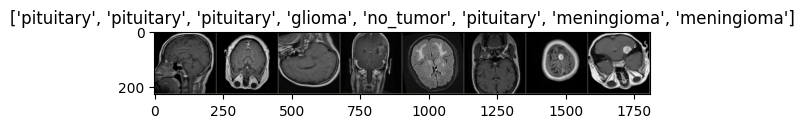

In [18]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}\nTotal Trainable Parameters: {trainable_params}")


Total params: 4012672
Total Trainable Parameters: 4012672


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [21]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

In [22]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(dataloader, desc='train', leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='valid', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            all_preds.append(preds.cpu().numpy().tolist())
            all_labels.append(labels.cpu().numpy().tolist())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc, all_preds, all_labels

In [23]:
NUM_EPOCHS = 80
best_val_acc = 0.0
best_model_path = 'efficientnetb0_brain_tumor.h5'

early_stopper = EarlyStopping(patience=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)

    scheduler.step(val_loss)
    early_stopper.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"    train_loss: {train_loss:.4f}    train_acc: {train_acc:.4f}")
    print(f"    val_loss: {val_loss:.4f}    val_acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"Saved new best model")

total_time = time.time() - start_time
print(f"Training Complete in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.4f}'")

Epoch 1/80


    train_loss: 0.6349    train_acc: 0.7770
    val_loss: 0.4212    val_acc: 0.8187
Saved new best model
Epoch 2/80


    train_loss: 0.3841    train_acc: 0.8702
    val_loss: 0.2495    val_acc: 0.9343
Saved new best model
Epoch 3/80


    train_loss: 0.2955    train_acc: 0.9027
    val_loss: 0.1948    val_acc: 0.9422
Saved new best model
Epoch 4/80


    train_loss: 0.2638    train_acc: 0.9062
    val_loss: 0.2465    val_acc: 0.9124
Epoch 5/80


    train_loss: 0.2446    train_acc: 0.9168
    val_loss: 0.1642    val_acc: 0.9363
Epoch 6/80


    train_loss: 0.2030    train_acc: 0.9363
    val_loss: 0.1498    val_acc: 0.9542
Saved new best model
Epoch 7/80


    train_loss: 0.1752    train_acc: 0.9475
    val_loss: 0.1479    val_acc: 0.9562
Saved new best model
Epoch 8/80


    train_loss: 0.1510    train_acc: 0.9510
    val_loss: 0.1826    val_acc: 0.9442
Epoch 9/80


    train_loss: 0.1832    train_acc: 0.9410
    val_loss: 0.1248    val_acc: 0.9582
Saved new best model
Epoch 10/80


    train_loss: 0.1504    train_acc: 0.9481
    val_loss: 0.2022    val_acc: 0.9382
Epoch 11/80


    train_loss: 0.1391    train_acc: 0.9522
    val_loss: 0.2232    val_acc: 0.9402
Epoch 12/80


    train_loss: 0.1570    train_acc: 0.9469
    val_loss: 0.1895    val_acc: 0.9402
Epoch 13/80


    train_loss: 0.1629    train_acc: 0.9493
    val_loss: 0.1451    val_acc: 0.9582
Epoch 14/80


    train_loss: 0.0952    train_acc: 0.9646
    val_loss: 0.0916    val_acc: 0.9761
Saved new best model
Epoch 15/80


    train_loss: 0.0621    train_acc: 0.9847
    val_loss: 0.1126    val_acc: 0.9701
Epoch 16/80


    train_loss: 0.0496    train_acc: 0.9835
    val_loss: 0.1146    val_acc: 0.9641
Epoch 17/80


    train_loss: 0.0401    train_acc: 0.9888
    val_loss: 0.0748    val_acc: 0.9801
Saved new best model
Epoch 18/80


    train_loss: 0.0584    train_acc: 0.9858
    val_loss: 0.1074    val_acc: 0.9701
Epoch 19/80


    train_loss: 0.0593    train_acc: 0.9794
    val_loss: 0.1528    val_acc: 0.9701
Epoch 20/80


    train_loss: 0.0634    train_acc: 0.9782
    val_loss: 0.1336    val_acc: 0.9641
Epoch 21/80


    train_loss: 0.0434    train_acc: 0.9864
    val_loss: 0.0823    val_acc: 0.9701
Epoch 22/80


    train_loss: 0.0203    train_acc: 0.9935
    val_loss: 0.0954    val_acc: 0.9741
Epoch 23/80


    train_loss: 0.0178    train_acc: 0.9941
    val_loss: 0.0733    val_acc: 0.9841
Saved new best model
Epoch 24/80


    train_loss: 0.0275    train_acc: 0.9882
    val_loss: 0.0802    val_acc: 0.9721
Epoch 25/80


    train_loss: 0.0164    train_acc: 0.9947
    val_loss: 0.0837    val_acc: 0.9741
Epoch 26/80


    train_loss: 0.0381    train_acc: 0.9847
    val_loss: 0.1027    val_acc: 0.9741
Epoch 27/80


    train_loss: 0.0118    train_acc: 0.9959
    val_loss: 0.0954    val_acc: 0.9841
Epoch 28/80


    train_loss: 0.0145    train_acc: 0.9941
    val_loss: 0.1038    val_acc: 0.9701
Epoch 29/80


    train_loss: 0.0109    train_acc: 0.9959
    val_loss: 0.1024    val_acc: 0.9801
Epoch 30/80


    train_loss: 0.0115    train_acc: 0.9959
    val_loss: 0.0984    val_acc: 0.9741
Epoch 31/80


    train_loss: 0.0083    train_acc: 0.9971
    val_loss: 0.0854    val_acc: 0.9761
Epoch 32/80


    train_loss: 0.0095    train_acc: 0.9965
    val_loss: 0.0916    val_acc: 0.9781
Epoch 33/80


    train_loss: 0.0043    train_acc: 0.9994
    val_loss: 0.0747    val_acc: 0.9761
Epoch 34/80


    train_loss: 0.0058    train_acc: 0.9982
    val_loss: 0.0814    val_acc: 0.9821
Epoch 35/80


    train_loss: 0.0043    train_acc: 0.9994
    val_loss: 0.0778    val_acc: 0.9821
Epoch 36/80


    train_loss: 0.0041    train_acc: 0.9982
    val_loss: 0.0760    val_acc: 0.9821
Epoch 37/80


    train_loss: 0.0036    train_acc: 0.9994
    val_loss: 0.0750    val_acc: 0.9841
Epoch 38/80


    train_loss: 0.0021    train_acc: 1.0000
    val_loss: 0.0736    val_acc: 0.9801
Epoch 39/80


    train_loss: 0.0051    train_acc: 0.9988
    val_loss: 0.0750    val_acc: 0.9801
Epoch 40/80


    train_loss: 0.0037    train_acc: 0.9994
    val_loss: 0.0755    val_acc: 0.9861
Saved new best model
Epoch 41/80


    train_loss: 0.0035    train_acc: 0.9988
    val_loss: 0.0842    val_acc: 0.9821
Epoch 42/80


    train_loss: 0.0026    train_acc: 0.9988
    val_loss: 0.0824    val_acc: 0.9821
Epoch 43/80


    train_loss: 0.0020    train_acc: 1.0000
    val_loss: 0.0754    val_acc: 0.9821
Epoch 44/80


    train_loss: 0.0028    train_acc: 0.9994
    val_loss: 0.0834    val_acc: 0.9801
Epoch 45/80


    train_loss: 0.0020    train_acc: 1.0000
    val_loss: 0.0773    val_acc: 0.9801
Epoch 46/80


    train_loss: 0.0022    train_acc: 0.9994
    val_loss: 0.0858    val_acc: 0.9841
Epoch 47/80


    train_loss: 0.0027    train_acc: 0.9994
    val_loss: 0.0760    val_acc: 0.9821
Epoch 48/80


    train_loss: 0.0036    train_acc: 0.9982
    val_loss: 0.0806    val_acc: 0.9821
Epoch 49/80


    train_loss: 0.0027    train_acc: 0.9994
    val_loss: 0.0927    val_acc: 0.9821
Epoch 50/80


    train_loss: 0.0049    train_acc: 0.9994
    val_loss: 0.0790    val_acc: 0.9801
Epoch 51/80


    train_loss: 0.0045    train_acc: 0.9994
    val_loss: 0.0787    val_acc: 0.9841
Epoch 52/80


    train_loss: 0.0022    train_acc: 0.9994
    val_loss: 0.0880    val_acc: 0.9801
Epoch 53/80


    train_loss: 0.0038    train_acc: 0.9988
    val_loss: 0.0938    val_acc: 0.9801
Epoch 54/80


    train_loss: 0.0025    train_acc: 0.9994
    val_loss: 0.0873    val_acc: 0.9821
Epoch 55/80


    train_loss: 0.0021    train_acc: 0.9994
    val_loss: 0.0891    val_acc: 0.9821
Epoch 56/80


    train_loss: 0.0029    train_acc: 0.9988
    val_loss: 0.0841    val_acc: 0.9801
Epoch 57/80


    train_loss: 0.0015    train_acc: 1.0000
    val_loss: 0.0900    val_acc: 0.9821
Epoch 58/80


    train_loss: 0.0023    train_acc: 0.9994
    val_loss: 0.0827    val_acc: 0.9801
Epoch 59/80


    train_loss: 0.0021    train_acc: 0.9994
    val_loss: 0.0900    val_acc: 0.9801
Epoch 60/80


    train_loss: 0.0020    train_acc: 1.0000
    val_loss: 0.0889    val_acc: 0.9821
Epoch 61/80


    train_loss: 0.0016    train_acc: 1.0000
    val_loss: 0.0870    val_acc: 0.9821
Epoch 62/80


    train_loss: 0.0067    train_acc: 0.9988
    val_loss: 0.0916    val_acc: 0.9821
Epoch 63/80


    train_loss: 0.0024    train_acc: 0.9994
    val_loss: 0.0822    val_acc: 0.9821
Epoch 64/80


    train_loss: 0.0028    train_acc: 0.9994
    val_loss: 0.0819    val_acc: 0.9801
Epoch 65/80


    train_loss: 0.0015    train_acc: 1.0000
    val_loss: 0.0836    val_acc: 0.9781
Epoch 66/80


    train_loss: 0.0046    train_acc: 0.9976
    val_loss: 0.0782    val_acc: 0.9781
Epoch 67/80


    train_loss: 0.0018    train_acc: 1.0000
    val_loss: 0.0853    val_acc: 0.9841
Epoch 68/80


    train_loss: 0.0029    train_acc: 0.9994
    val_loss: 0.0843    val_acc: 0.9801
Epoch 69/80


    train_loss: 0.0057    train_acc: 0.9976
    val_loss: 0.0747    val_acc: 0.9801
Epoch 70/80


    train_loss: 0.0024    train_acc: 1.0000
    val_loss: 0.0814    val_acc: 0.9821
Epoch 71/80


    train_loss: 0.0091    train_acc: 0.9982
    val_loss: 0.0880    val_acc: 0.9801
Epoch 72/80


    train_loss: 0.0012    train_acc: 1.0000
    val_loss: 0.0817    val_acc: 0.9841
Epoch 73/80


    train_loss: 0.0019    train_acc: 1.0000
    val_loss: 0.0873    val_acc: 0.9821
Epoch 74/80


    train_loss: 0.0029    train_acc: 0.9994
    val_loss: 0.0782    val_acc: 0.9821
Epoch 75/80


    train_loss: 0.0019    train_acc: 1.0000
    val_loss: 0.0884    val_acc: 0.9821
Epoch 76/80


    train_loss: 0.0049    train_acc: 0.9988
    val_loss: 0.0809    val_acc: 0.9821
Epoch 77/80


    train_loss: 0.0045    train_acc: 0.9988
    val_loss: 0.0856    val_acc: 0.9821
Epoch 78/80


    train_loss: 0.0037    train_acc: 0.9988
    val_loss: 0.0834    val_acc: 0.9821
Epoch 79/80


    train_loss: 0.0019    train_acc: 0.9994
    val_loss: 0.0836    val_acc: 0.9821
Epoch 80/80


    train_loss: 0.0029    train_acc: 0.9988
    val_loss: 0.0807    val_acc: 0.9821
Training Complete in 54.11 minutes. Best val acc: 0.9861'


In [24]:
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)

val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)
print('Final validation loss: {:.4f}, acc: {:.4f}'.format(val_loss, val_acc))

Final validation loss: 0.0755, acc: 0.9861


Confusion Matrix:
 [[161   0   0   0]
 [  0 119   4   1]
 [  1   1  97   0]
 [  0   0   0 118]]
Classification Report:
               precision    recall  f1-score   support

      glioma     0.9938    1.0000    0.9969       161
  meningioma     0.9917    0.9597    0.9754       124
    no_tumor     0.9604    0.9798    0.9700        99
   pituitary     0.9916    1.0000    0.9958       118

    accuracy                         0.9861       502
   macro avg     0.9844    0.9849    0.9845       502
weighted avg     0.9862    0.9861    0.9860       502



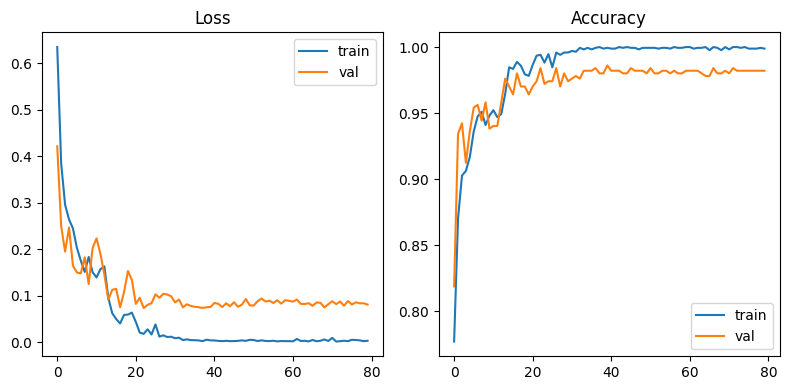

In [25]:
val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names, digits=4))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()